<a href="https://colab.research.google.com/github/nour614/Stroke-Prediction-/blob/main/Nour_Tafa_Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Stroke Prediton**##

**Content**

Stroke is the second leading cause of death worldwide, accounting for around 11% of all deaths, according to the World Health Organization. The data set predicts the likelihood of a patient having a stroke based on input parameters such as gender, age, various diseases, and smoking status, with each row containing relevant patient information.

Each row represents a pacient 5110

Classification Problem

This data set has 11 columns and the Target is Stroke




**Culumn** | **Description**  
--- | ---
id|unique identifier
age |age of the patient
gender| "Male", "Female" or "Other"
hypertension| 0 hypertension, 1  hypertension
heart_disease |0  doesn't have diseases, 1  has a heart disease
ever_married| "No" or "Yes"
work_type |"children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
Residence_type|"Rural" or "Urban"
avg_glucose_level| average glucose level in blood
bmi| body mass index
smoking_status| "formerly smoked", "never smoked", "smokes" or "Unknown"
stroke| 1if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient



In [ ]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatplotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn import metrics

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier


## Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay


## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [ ]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            cmap='Blues', normalize=None, classes=None, 
                            figsize=(20,5), name='Classification Model', 
                            average='binary', zero_division=0):
  """Takes as required arguments: a model, traing features, training labels,
  testing feature, testing labels
  Prints a classification reports and confusion matrics for each data set
  returns a dataframe of metrics

  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure
    name: give your model a name
    average: how to aggregate scores for multiclass problems
    zero_division: what should the result of divide by zero be?"""

  # Gather model predictions
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  # Display classification report and confusion matrices
  print('======Train Set Metrics======')
  print(metrics.classification_report(y_train, train_preds, 
                                      zero_division=0,
                                      target_names=classes))
  
  print('======Test Set Metrics======')
  print(metrics.classification_report(y_test, test_preds, 
                                      zero_division=0,
                                      target_names=classes))

  fig, axes = plt.subplots(ncols=2, figsize=figsize)

  ConfusionMatrixDisplay.from_predictions(y_train, train_preds, cmap=cmap, 
                                display_labels=classes,
                                normalize=normalize, ax=axes[0])
  axes[0].set_title('Train Confusion Matrix')

  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap=cmap, 
                              display_labels=classes,
                              normalize=normalize, ax=axes[1])
  axes[1].set_title('Test Confusion Matrix')
  plt.show()

  # If there are more than 2 classes and an average has not been set, 
  # set average to 'macro'
  if average == 'binary' and y_train.nunique() > 2:
    average = 'macro'

  # Create a dataframe of scores to return
  scores = pd.DataFrame()
  
  # Training

  scores.loc[name, 'Train Accuracy'] = accuracy_score(y_train, train_preds)
  scores.loc[name, 'Train Recall'] = recall_score(y_train, train_preds,
                                                           average=average,
                                                       zero_division=zero_division)
  scores.loc[name, 'Train Precision'] = precision_score(y_train, train_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Train F1-Score'] = f1_score(y_train, train_preds,
                                                           average=average,
                                                     zero_division=zero_division)
  
  # Testing
  scores.loc[name, 'Test Accuracy'] = accuracy_score(y_test, test_preds)
  scores.loc[name, 'Test Recall'] = recall_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test Precision'] = precision_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test F1-Score'] = f1_score(y_test, test_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  return scores

## **1. Load and inspect the data**

In [ ]:
df = pd.read_csv('/content/sample_data/healthcare-dataset-stroke-data 2.csv')

In [ ]:
backup_df = df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.shape

(5110, 12)

In [ ]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [ ]:
df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [ ]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

##**2.  Cleaning The Data**##

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
df = df.drop(['id', 'work_type', 'Residence_type'], axis=1)

In [ ]:
cat_cols = make_column_selector(dtype_include='object')(df)
for col in cat_cols:
  display(df[col].value_counts(normalize=True))

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64

never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64

In [ ]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [ ]:
df.rename(columns={'gender':'isfemale'}, inplace=True)

In [ ]:
df['isfemale'].replace({'Male': 0,'Other':0 ,'Female':1}, inplace=True)

In [ ]:
df['isfemale'].value_counts()

1    2994
0    2116
Name: isfemale, dtype: int64

In [ ]:
df['ever_married'].replace({'Yes':1,'No':0}, inplace=True)

In [ ]:
df['ever_married'].value_counts()

1    3353
0    1757
Name: ever_married, dtype: int64

In [ ]:
df['smoking_status'].replace({'never smoked':0,'Unknown':1,'formerly smoked':2,  
'smokes':3 },inplace=True)

##**Visualization**

**1. BoxPlot**

    a. Age Boxplot

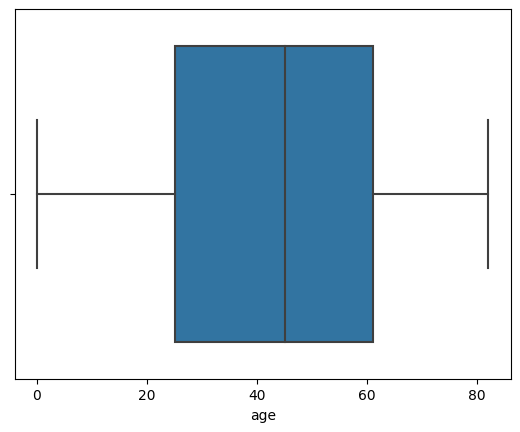

In [ ]:
ax = sns.boxplot(x = 'age', data = df)

There are no age outliers 

    b. Avg glucose level Boxplot
    

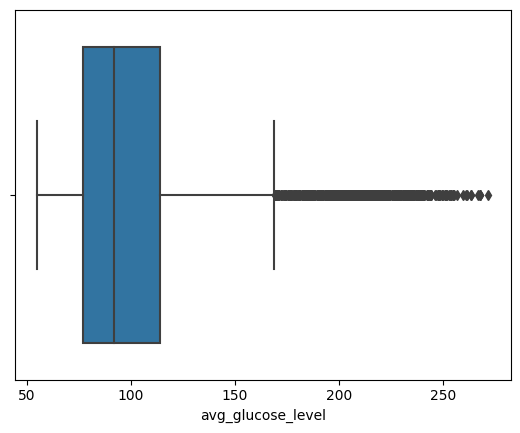

In [ ]:
ax = sns.boxplot(x = 'avg_glucose_level', data = df)

The boxplot shows a large number of outliers 

    c. Body Mass Index Boxplot

Text(0.5, 1.0, 'Body Mass Index')

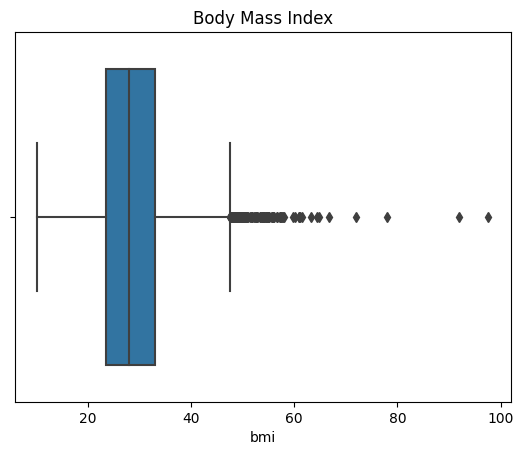

In [ ]:
ax = sns.boxplot(x = 'bmi', data = df)
plt.title("Body Mass Index")


The boxplot shows a large number of outliers

**2.  Histogram**

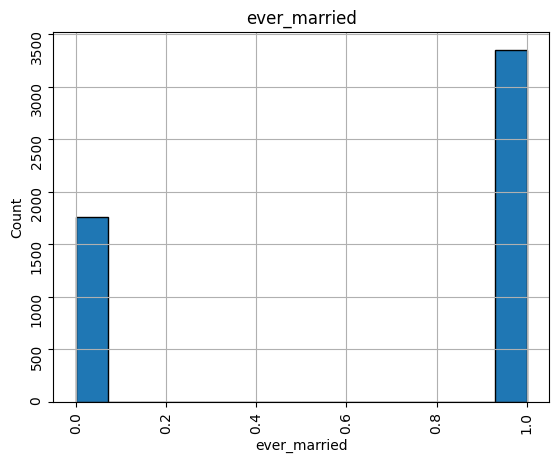

In [ ]:
ax = df['ever_married'].hist(bins='auto', edgecolor='black')
ax.set_xlabel('ever_married')
ax.set_ylabel('Count')

ax.set_title('ever_married')

ax.tick_params(rotation = 90)

Based on the histogram, it appears that there is a higher frequency of individuals who are married compared to those who are not.

**3.  Scatter Plot**

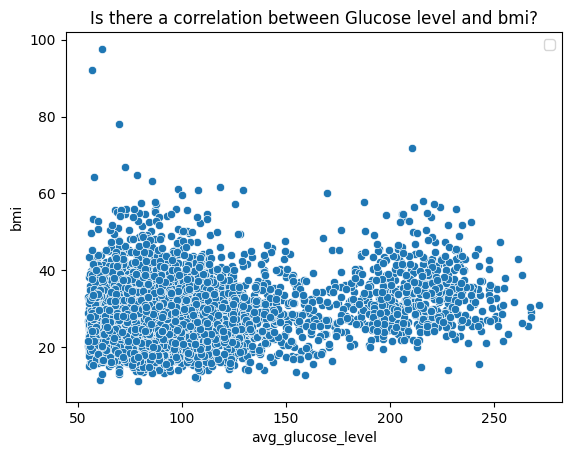

In [ ]:
ax = sns.scatterplot(data=df, x = 'avg_glucose_level', y = 'bmi')
ax.set_title('Is there a correlation between Glucose level and bmi?')
ax.legend(bbox_to_anchor=[1,1]);

Based on the scatter plot, it appears that there is a positive correlation between bmi and glucose level.


**4. BMI Historgam**

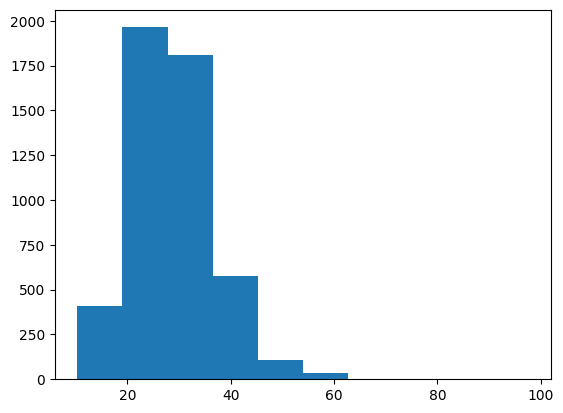

In [ ]:
plt.hist(df['bmi'])
ax.set_xlabel('bmi')
ax.set_ylabel('Count')
ax.set_title('Body Mass Index')
plt.show()

The histogram indicates that there is a significant percentage of patients with high BMI.

**5. Violin Plot**


<Axes: xlabel='stroke', ylabel='hypertension'>

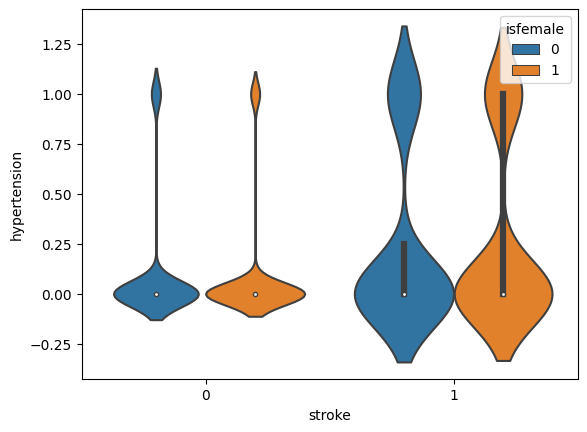

In [ ]:
sns.violinplot(x="stroke", y="hypertension", hue="isfemale", data=df)


This violin plot depicts a clear pattern where there is a high concentration of women with hypertension who are at risk of getting strokes. The plot suggests that the female group has a higher incidence of hypertension, and within the female group, hypertension is more common among women who can get strokes.

**6. Scatter/Countplot**

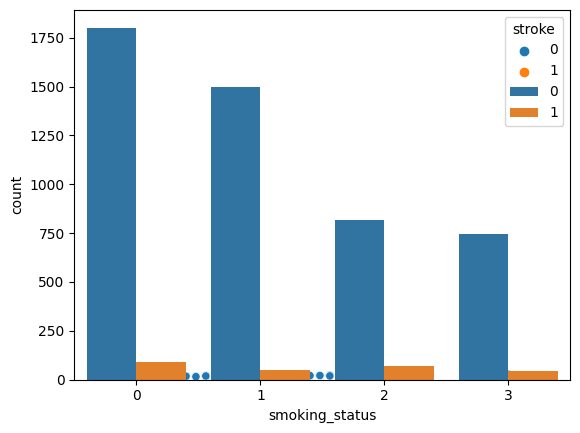

In [ ]:
sns.scatterplot(data=df, x="age", y="bmi", hue="stroke")

# create count plot of smoking status
sns.countplot(data=df, x="smoking_status", hue="stroke")

# display plots
plt.show()

Based on the scatter plot showing age versus BMI in relation to stroke incidence, we can observe that there is a positive correlation between age and BMI, and this correlation can contribute to an increased risk of stroke. As age and BMI increase, the likelihood of having a stroke also increases.
the count plot showing smoking status versus stroke incidence indicates that smoking status may not have a strong correlation with stroke risk

**7. Heatmap**

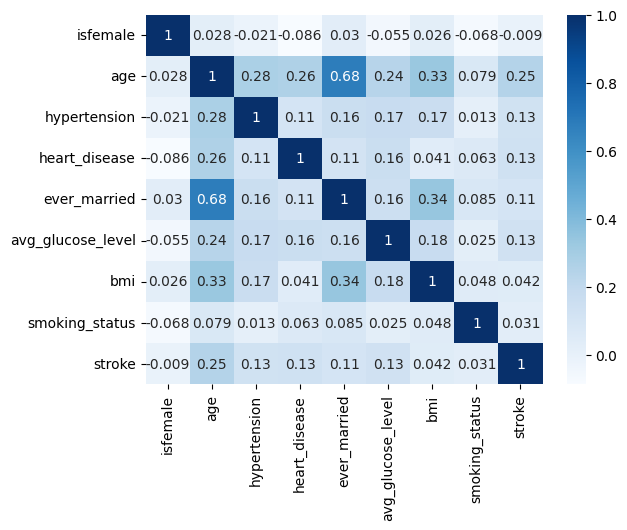

In [ ]:
corr=df.corr()
ax = sns.heatmap(corr, cmap= 'Blues', annot = True)
plt.show()

The heatmap indicates that there is a stronger correlation between BMI, marital status, and age than hypertension, glucose level, and heart disease.

##Modeling##

Train Test Split

In [ ]:
y = df['stroke']
X=df.drop(columns=['stroke'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Preprocess the data

In [ ]:
mean_imputer= SimpleImputer(missing_values=np.NaN, strategy='mean')


In [ ]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [ ]:
scaler = StandardScaler()
ohe= OneHotEncoder(handle_unknown="ignore")

In [ ]:
mean_pipe=make_pipeline(scaler,mean_imputer)

In [ ]:
number_tuple = (mean_pipe, num_selector)
category_tuple = (ohe,cat_selector)

In [ ]:
preprocessor = make_column_transformer(number_tuple, 
                                       category_tuple, 
                                       remainder='drop',
                                       verbose_feature_names_out=False)

In [ ]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f63658b3b80>)],
                  verbose_feature_names_out=False)

Random Forest 

In [ ]:
## Create an instance of the model
rf = RandomForestClassifier(random_state=42)

## Create a model pipeline
rf_pipe = make_pipeline(preprocessor, rf)

## Fit the model
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f63658b3b80>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3663
           1       1.00      1.00      1.00       169

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278



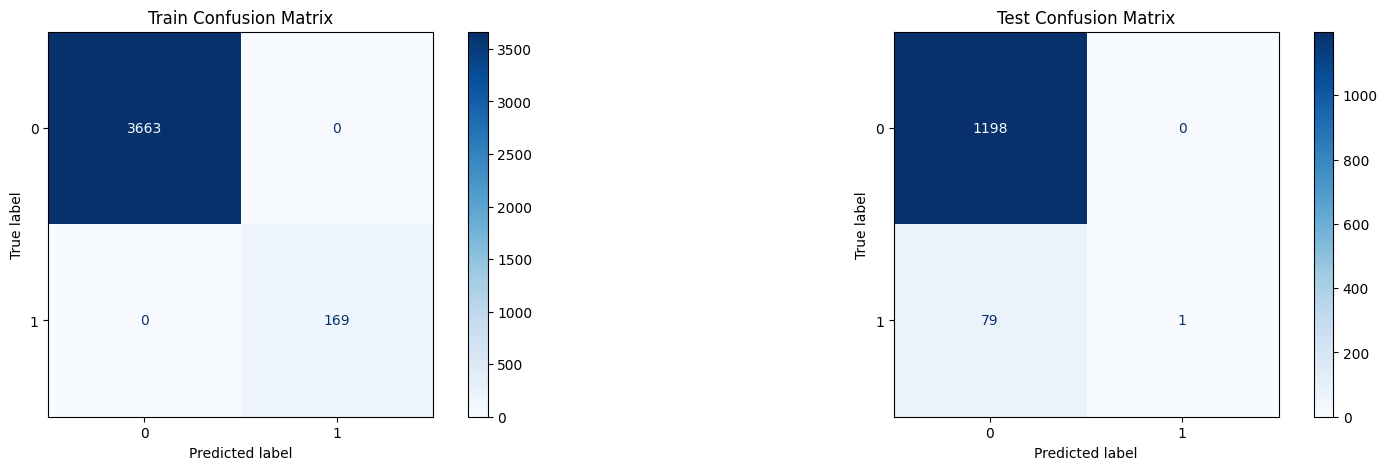

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
Random forest,1.0,1.0,1.0,1.0,0.938185,0.0125,1.0,0.024691


In [ ]:
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test, 
                        name='Random forest')

Random Forest GridSearch

In [ ]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler()),
                                                    ('simpleimputer',
                                                     SimpleImputer())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f63658b3b80>)],
                     verbose_feature_names_out=False)),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline',
                            

In [ ]:
rf_params_gs = {"randomforestclassifier__max_depth": list(range(1,15)), 
                  "randomforestclassifier__n_estimators": list(range(1,10,25))}

In [ ]:
rf_gs = GridSearchCV(rf_pipe, rf_params_gs)

In [ ]:
rf_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f63658b3b80>)],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14],
                         'randomforestclassifier__n_estimators': [1]})

In [ ]:
# Create a model pipeline
rf_gs_pipe = rf_gs.best_estimator_

## Fit the model
rf_gs_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6378dd8940>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6378ddb460>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=1, n_estimators=1,
                                        random_state=42))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.91      0.96      0.93      3832

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



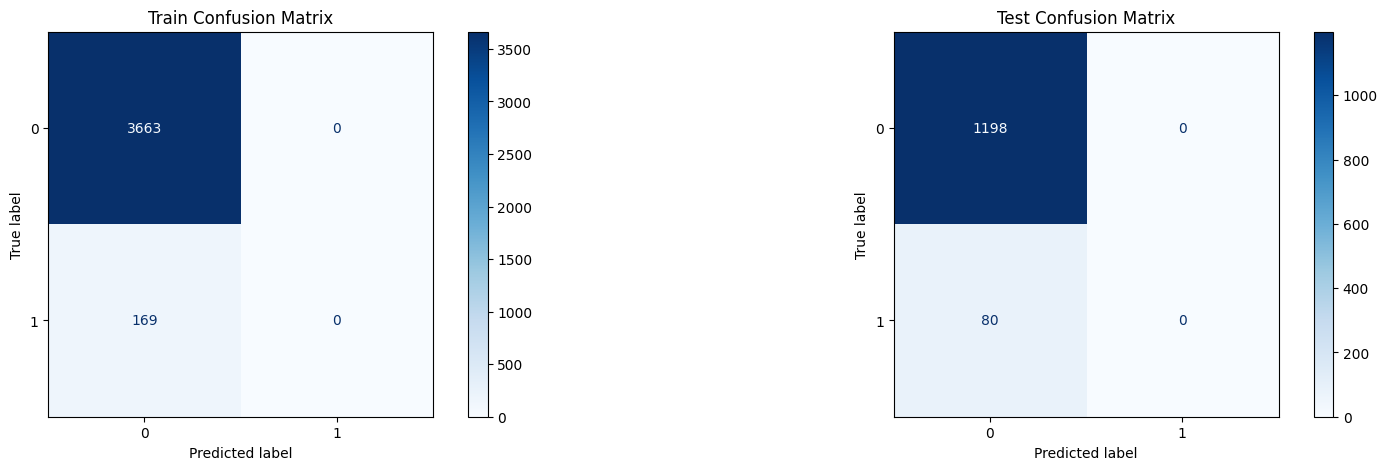

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
Random Forest Tuned,0.955898,0.0,0.0,0.0,0.937402,0.0,0.0,0.0


In [ ]:
evaluate_classification(rf_gs_pipe, X_train, y_train, X_test, y_test,
                             name='Random Forest Tuned')

XGBoosting

In [ ]:
## Create an instance of the model
xgb = XGBClassifier(random_state=42)
## Create a model pipeline
xgb_pipe = make_pipeline(preprocessor, xgb)
## Fit the model
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_c...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3663
           1       1.00      0.91      0.95       169

    accuracy                           1.00      3832
   macro avg       1.00      0.96      0.98      3832
weighted avg       1.00      1.00      1.00      3832

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1198
           1       0.40      0.07      0.13        80

    accuracy                           0.94      1278
   macro avg       0.67      0.53      0.55      1278
weighted avg       0.91      0.94      0.91      1278



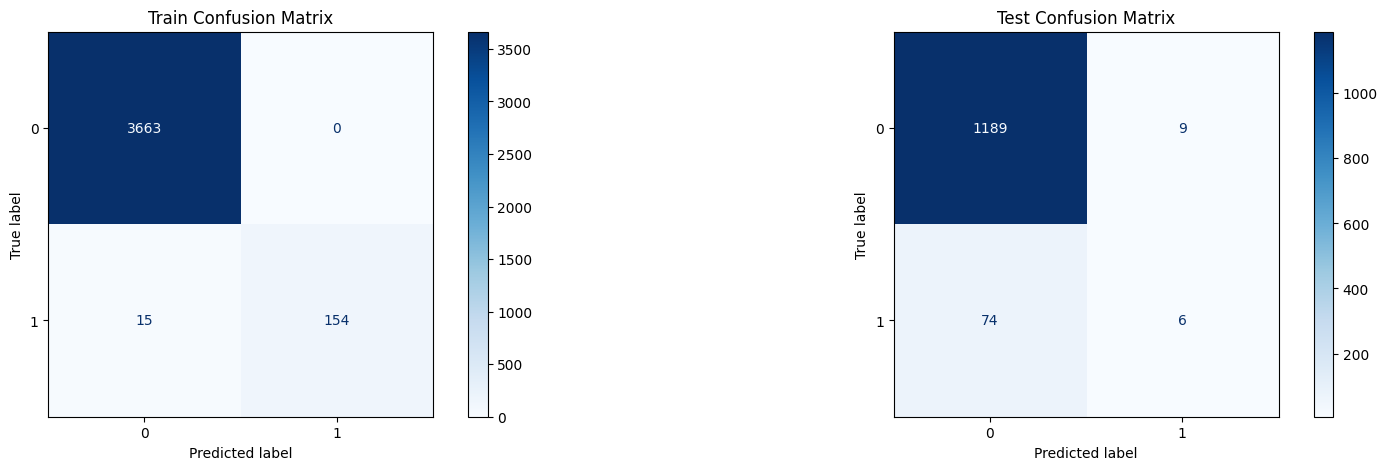

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
XGBoost,0.996086,0.911243,1.0,0.95356,0.935055,0.075,0.4,0.126316


In [ ]:
## Display the Model's metrics
evaluate_classification(xgb_pipe, X_train, y_train, X_test, y_test, name='XGBoost')


XGBoosting Gridsearch

In [ ]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler()),
                                                    ('simpleimputer',
                                                     SimpleImputer())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f63658b3b80>)],
                     verbose_feature_names_out=False)),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None

In [ ]:
xgb_params = {'xgbclassifier__n_estimators':[10, 25, 50],
          'xgbclassifier__max_depth':range(1, 15)}


======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       1.00      0.02      0.03       169

    accuracy                           0.96      3832
   macro avg       0.98      0.51      0.51      3832
weighted avg       0.96      0.96      0.94      3832

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



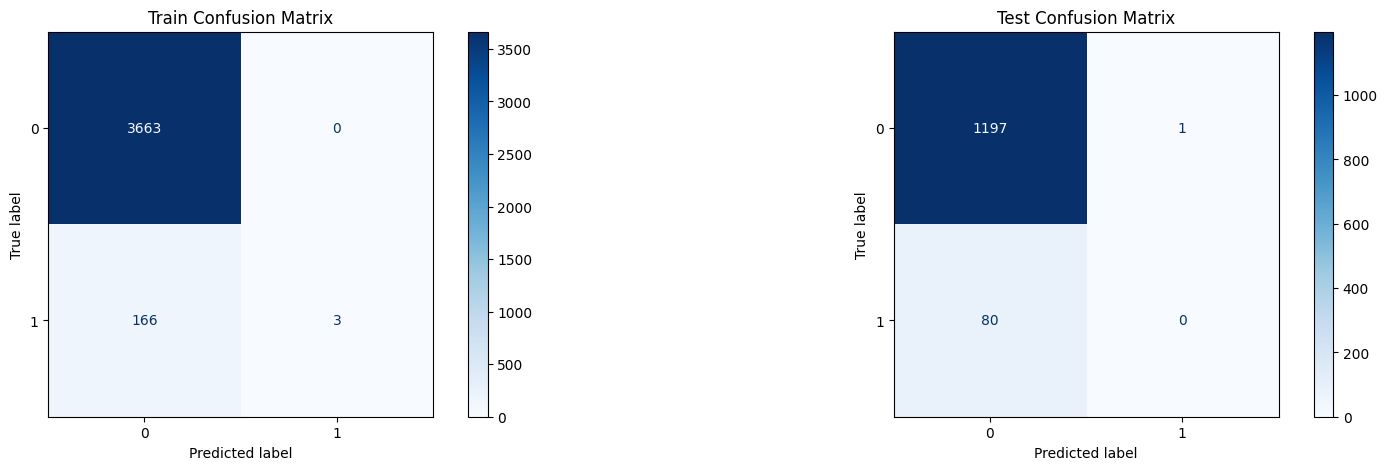

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
tuned_xgb,0.956681,0.017751,1.0,0.034884,0.93662,0.0,0.0,0.0


In [ ]:
## Create a model pipeline
xgb_gs = GridSearchCV(xgb_pipe, xgb_params)

##Fit the Model
xgb_gs.fit(X_train, y_train)

evaluate_classification(xgb_gs, X_train, y_train, 
                                           X_test, y_test, 
                                           name='tuned_xgb')

Logistic Regression Model 

In [ ]:
## Create an instance of the model
log_reg = LogisticRegression(max_iter=1000, class_weight=None)
## Create a model pipeline
log_reg_pipe = make_pipeline(preprocessor, log_reg)
## Fit the model
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f63658b3b80>)],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.91      0.96      0.93      3832

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



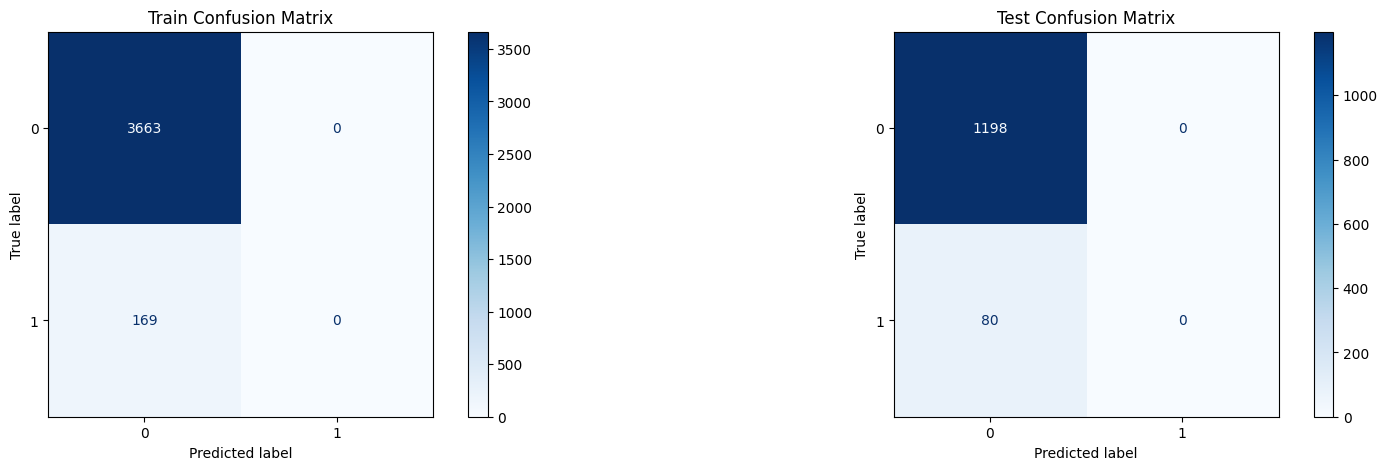

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.955898,0.0,0.0,0.0,0.937402,0.0,0.0,0.0


In [ ]:
evaluate_classification(log_reg_pipe, X_train, y_train, X_test, y_test, 
                        name='log_reg ')


Logistic Regression GridSearch

In [ ]:
log_reg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler()),
                                                    ('simpleimputer',
                                                     SimpleImputer())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f63658b3b80>)],
                     verbose_feature_names_out=False)),
  ('logisticregression', LogisticRegression(max_iter=1000))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipe

In [ ]:
log_reg_params = {'logisticregression__C': [.01,.10,1.0,10.,100.],
                  'logisticregression__penalty': ["l1","l2",None]}

In [ ]:
log_reg_gs = GridSearchCV(log_reg_pipe, log_reg_params)

In [ ]:
log_reg_gs.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f63658b3b80>)],
                                                          verbose_feature_names_out=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'logisticregression__penalty': ['l1', 'l2', None]})

In [ ]:
# Create a model pipeline
log_reg_gs_pipe = log_reg_gs.best_estimator_

## Fit the model
log_reg_gs_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f63777265f0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6377727e50>)],
                                   verbose_feature_names_out=False)),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=1000))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.91      0.96      0.93      3832

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



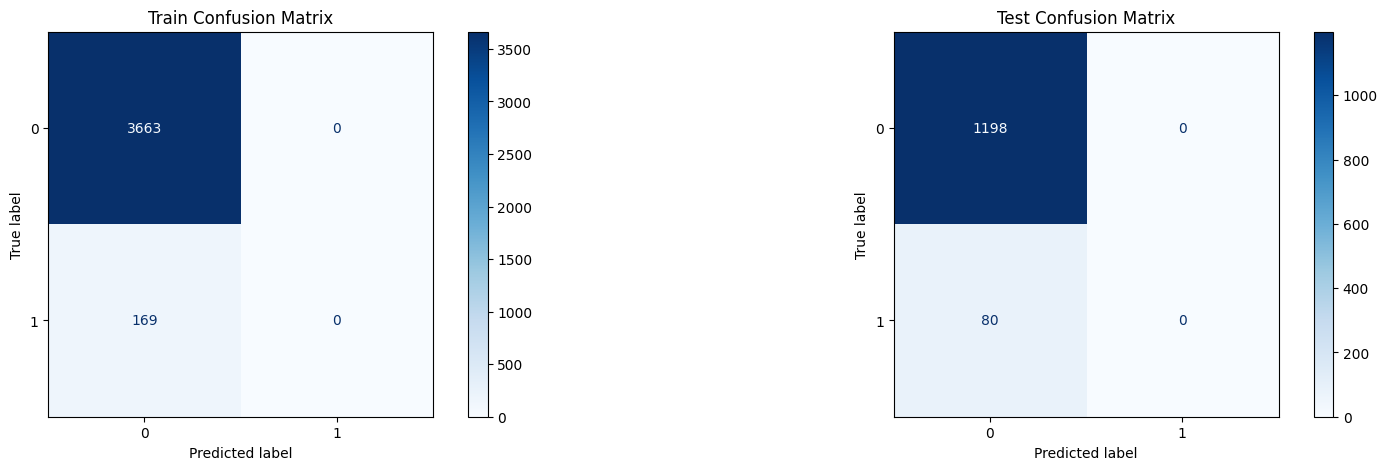

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
Tuned LogReg,0.955898,0.0,0.0,0.0,0.937402,0.0,0.0,0.0


In [ ]:
evaluate_classification(log_reg_gs_pipe, X_train, y_train, X_test, y_test,
                           name='Tuned LogReg')

Applying PCA to Random Forest

In [ ]:
scaler = StandardScaler(with_mean=False)
preprocessor_scaler = make_pipeline(preprocessor,scaler)

In [ ]:
pca = PCA(n_components=.95)
scaled_df = preprocessor_scaler.fit_transform(df)
pcs = pca.fit(scaled_df)

Random Forest PCA

In [ ]:
rf = RandomForestClassifier()
preprocessorpca_pipe = make_pipeline(preprocessor, pca)

In [ ]:
rf_pca_pipe = make_pipeline(preprocessorpca_pipe, rf)

In [ ]:
rf_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler()),
                                                                                   ('simpleimputer',
                                                                                    SimpleImputer())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f63658b3b80>)],
                                                    verbose_feature_names_out=False)),
                                 ('pca', PCA(n_components=0.95))])),
                ('randomforestclassifier', RandomForestClassifier())])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3663
           1       1.00      1.00      1.00       169

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.50      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.72      0.51      0.50      1278
weighted avg       0.91      0.94      0.91      1278



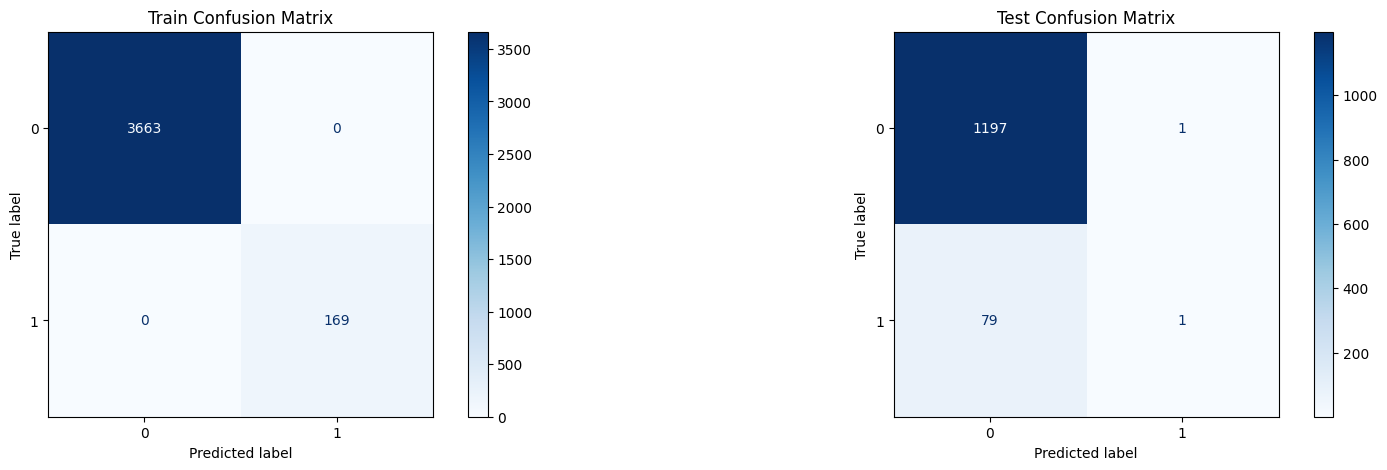

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
RandomForest PCA Model,1.0,1.0,1.0,1.0,0.937402,0.0125,0.5,0.02439


In [ ]:
evaluate_classification(rf_pca_pipe, X_train, y_train, X_test, y_test,
                            name="RandomForest PCA Model")

Applying PCA to XGB

In [ ]:
xgb = XGBClassifier(random_state=42)

In [ ]:
xgb_pca_pipe = make_pipeline(preprocessorpca_pipe, xgb)

In [ ]:
xgb_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler()),
                                                                                   ('simpleimputer',
                                                                                    SimpleImputer())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f636578a320>),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   <sklearn.compos...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3663
           1       1.00      1.00      1.00       169

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1198
           1       0.18      0.03      0.04        80

    accuracy                           0.93      1278
   macro avg       0.56      0.51      0.50      1278
weighted avg       0.89      0.93      0.91      1278



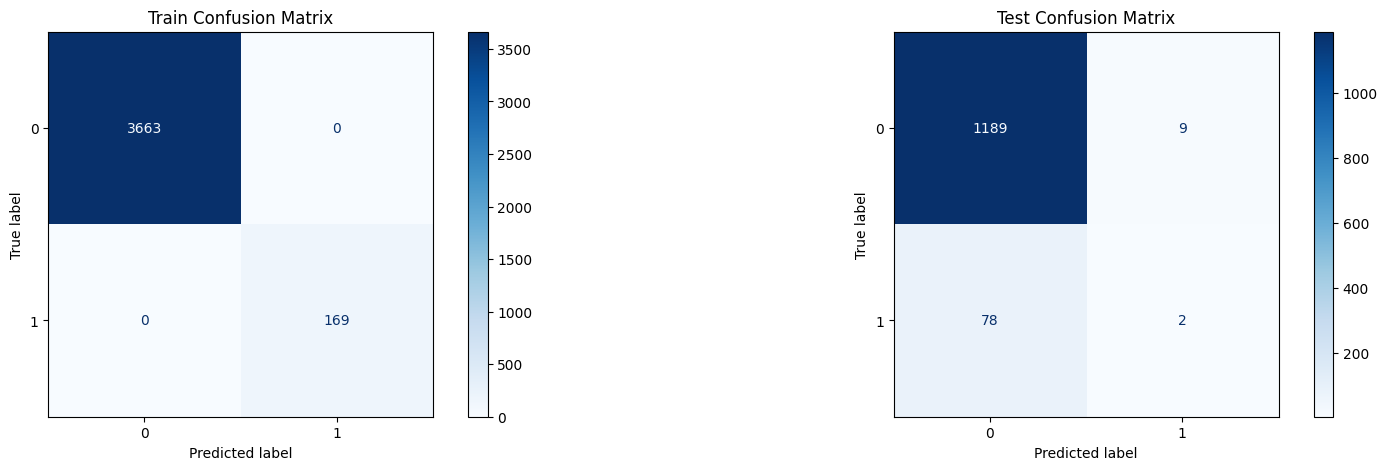

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
XGB PCA Model,1.0,1.0,1.0,1.0,0.931925,0.025,0.181818,0.043956


In [ ]:
evaluate_classification(xgb_pca_pipe, X_train, y_train, X_test, y_test,
                            name="XGB PCA Model")

All of the classification models performed similarly in terms of their evaluation metrics, but the XGBoost and PCA Random Forest models had the best macro average scores and the least false positive and false negative results.